<a href="https://www.kaggle.com/code/averma111/pytorch-ps-s3e14-skorch?scriptVersionId=128970810" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.7/193.7 kB 2.8 MB/s eta 0:00:00a 0:00:01


In [34]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
warnings.filterwarnings('ignore')
seed = 17
torch.manual_seed(seed)
np.random.seed(seed)
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import skorch

## Global Setting

In [3]:
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

## Assigning the directory and file paths

In [4]:
ROOT_PATH='/kaggle/input/playground-series-s3e14'
train_file = 'train.csv'
test_file = 'test.csv'
sample = 'sample_submission.csv'
original = '/kaggle/input/wild-blueberry-yield-prediction/Data in Brief/Data in Brief/WildBlueberryPollinationSimulationData.csv'

## Reading the train data

In [5]:
train = pd.read_csv(ROOT_PATH+'/'+train_file)
train.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [6]:
train.drop('id',axis=1,inplace=True)

In [7]:
test = pd.read_csv(ROOT_PATH+'/'+test_file)
test.head()

,id,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds
0,15289,25.0,0.25,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.399367,0.408088,31.394569
1,15290,12.5,0.25,0.25,0.75,0.63,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.488048,0.442866,36.846956
2,15291,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.583379,0.487057,40.037644
3,15292,25.0,0.50,0.38,0.38,0.63,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.433014,0.422847,33.116091
4,15293,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,24.0,0.39,0.360996,0.388860,29.558019


In [8]:
original_df = pd.read_csv(original)
original_df.head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [9]:
original_df.drop('Row#',axis=1,inplace=True)

In [10]:
original_df.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


In [11]:
train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [12]:
df_full = pd.concat([train, original_df])

## Defining the summary function

In [13]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['inf'] = np.isinf(df).sum().sum()
    summ['duplicate'] = df.duplicated().sum()
    return summ

##  Summary of the trained data

In [14]:
summary('train',df_full)

train shape: (16066, 17)


,dtypes,null,unique,min,median,max,mean,std,inf,duplicate
clonesize,float64,0,6,10.000000,25.000000,40.000000,19.659374,6.618134,0,7
honeybee,float64,0,7,0.000000,0.500000,18.430000,0.390660,0.413259,0,7
bumbles,float64,0,12,0.000000,0.250000,0.585000,0.286556,0.060249,0,7
andrena,float64,0,17,0.000000,0.500000,0.750000,0.491522,0.148849,0,7
osmia,float64,0,16,0.000000,0.630000,0.750000,0.590890,0.141209,0,7
MaxOfUpperTRange,float64,0,6,69.700000,86.000000,94.600000,82.175072,9.148725,0,7
MinOfUpperTRange,float64,0,5,39.000000,52.000000,57.200000,49.674599,5.548630,0,7
AverageOfUpperTRange,float64,0,5,58.200000,71.900000,79.000000,68.659486,7.643286,0,7
MaxOfLowerTRange,float64,0,6,50.200000,62.000000,68.200000,59.233400,6.612254,0,7
MinOfLowerTRange,float64,0,7,24.300000,30.000000,33.000000,28.661988,3.195960,0,7



* No null values. We therefore dont need to use imputation
* Categorical data ==> No Categorical data
* Data types are all float values excluding the target (integer)
* Data is reasonably small with only 15289 datapoints
* Duplicates: 7 duplicate

In [15]:
df_full = df_full.drop_duplicates()

In [16]:
summary('full',df_full)

full shape: (16059, 17)


,dtypes,null,unique,min,median,max,mean,std,inf,duplicate
clonesize,float64,0,6,10.000000,25.000000,40.000000,19.657824,6.615589,0,0
honeybee,float64,0,7,0.000000,0.500000,18.430000,0.390628,0.413323,0,0
bumbles,float64,0,12,0.000000,0.250000,0.585000,0.286556,0.060249,0,0
andrena,float64,0,17,0.000000,0.500000,0.750000,0.491548,0.148837,0,0
osmia,float64,0,16,0.000000,0.630000,0.750000,0.590906,0.141169,0,0
MaxOfUpperTRange,float64,0,6,69.700000,86.000000,94.600000,82.174955,9.149359,0,0
MinOfUpperTRange,float64,0,5,39.000000,52.000000,57.200000,49.674525,5.549016,0,0
AverageOfUpperTRange,float64,0,5,58.200000,71.900000,79.000000,68.659381,7.643815,0,0
MaxOfLowerTRange,float64,0,6,50.200000,62.000000,68.200000,59.233315,6.612713,0,0
MinOfLowerTRange,float64,0,7,24.300000,30.000000,33.000000,28.661947,3.196182,0,0


## Feature Engineering

In [17]:
df_full["fruit_seed"] = df_full["fruitset"] * df_full["seeds"]
df_full['insects'] = df_full['honeybee'] + df_full['bumbles'] + df_full['andrena'] + df_full['osmia']
df_full["AverageTRange"]=(df_full["AverageOfUpperTRange"]+df_full["AverageOfLowerTRange"])/2

test["AverageTRange"]=(test["AverageOfUpperTRange"]+test["AverageOfLowerTRange"])/2
test["fruit_seed"] = test["fruitset"] * test["seeds"]
test['insects'] = test['honeybee'] + test['bumbles'] + test['andrena'] + test['osmia']

## Pairplot of the train dataset

* Distribution looks fairely normal with -negative skewness

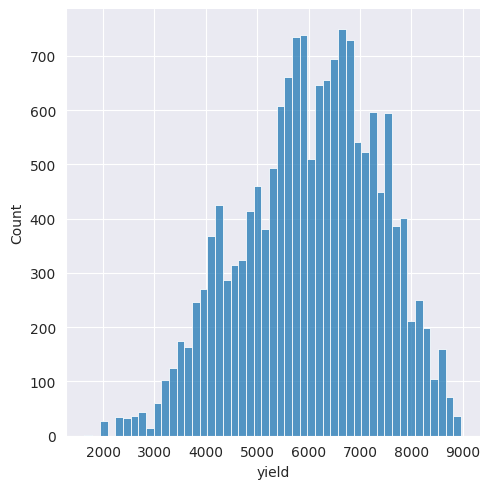

In [18]:
sns.displot(df_full['yield'])


## Distribution of Train vs Test data

* The distribution of Test and Train datasets seem to align

In [19]:
y = df_full['yield']
df_full.drop(columns=['yield','MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays'],axis=1,inplace=True)
X = df_full.copy()

## Distribution of Train and Test look synonimous

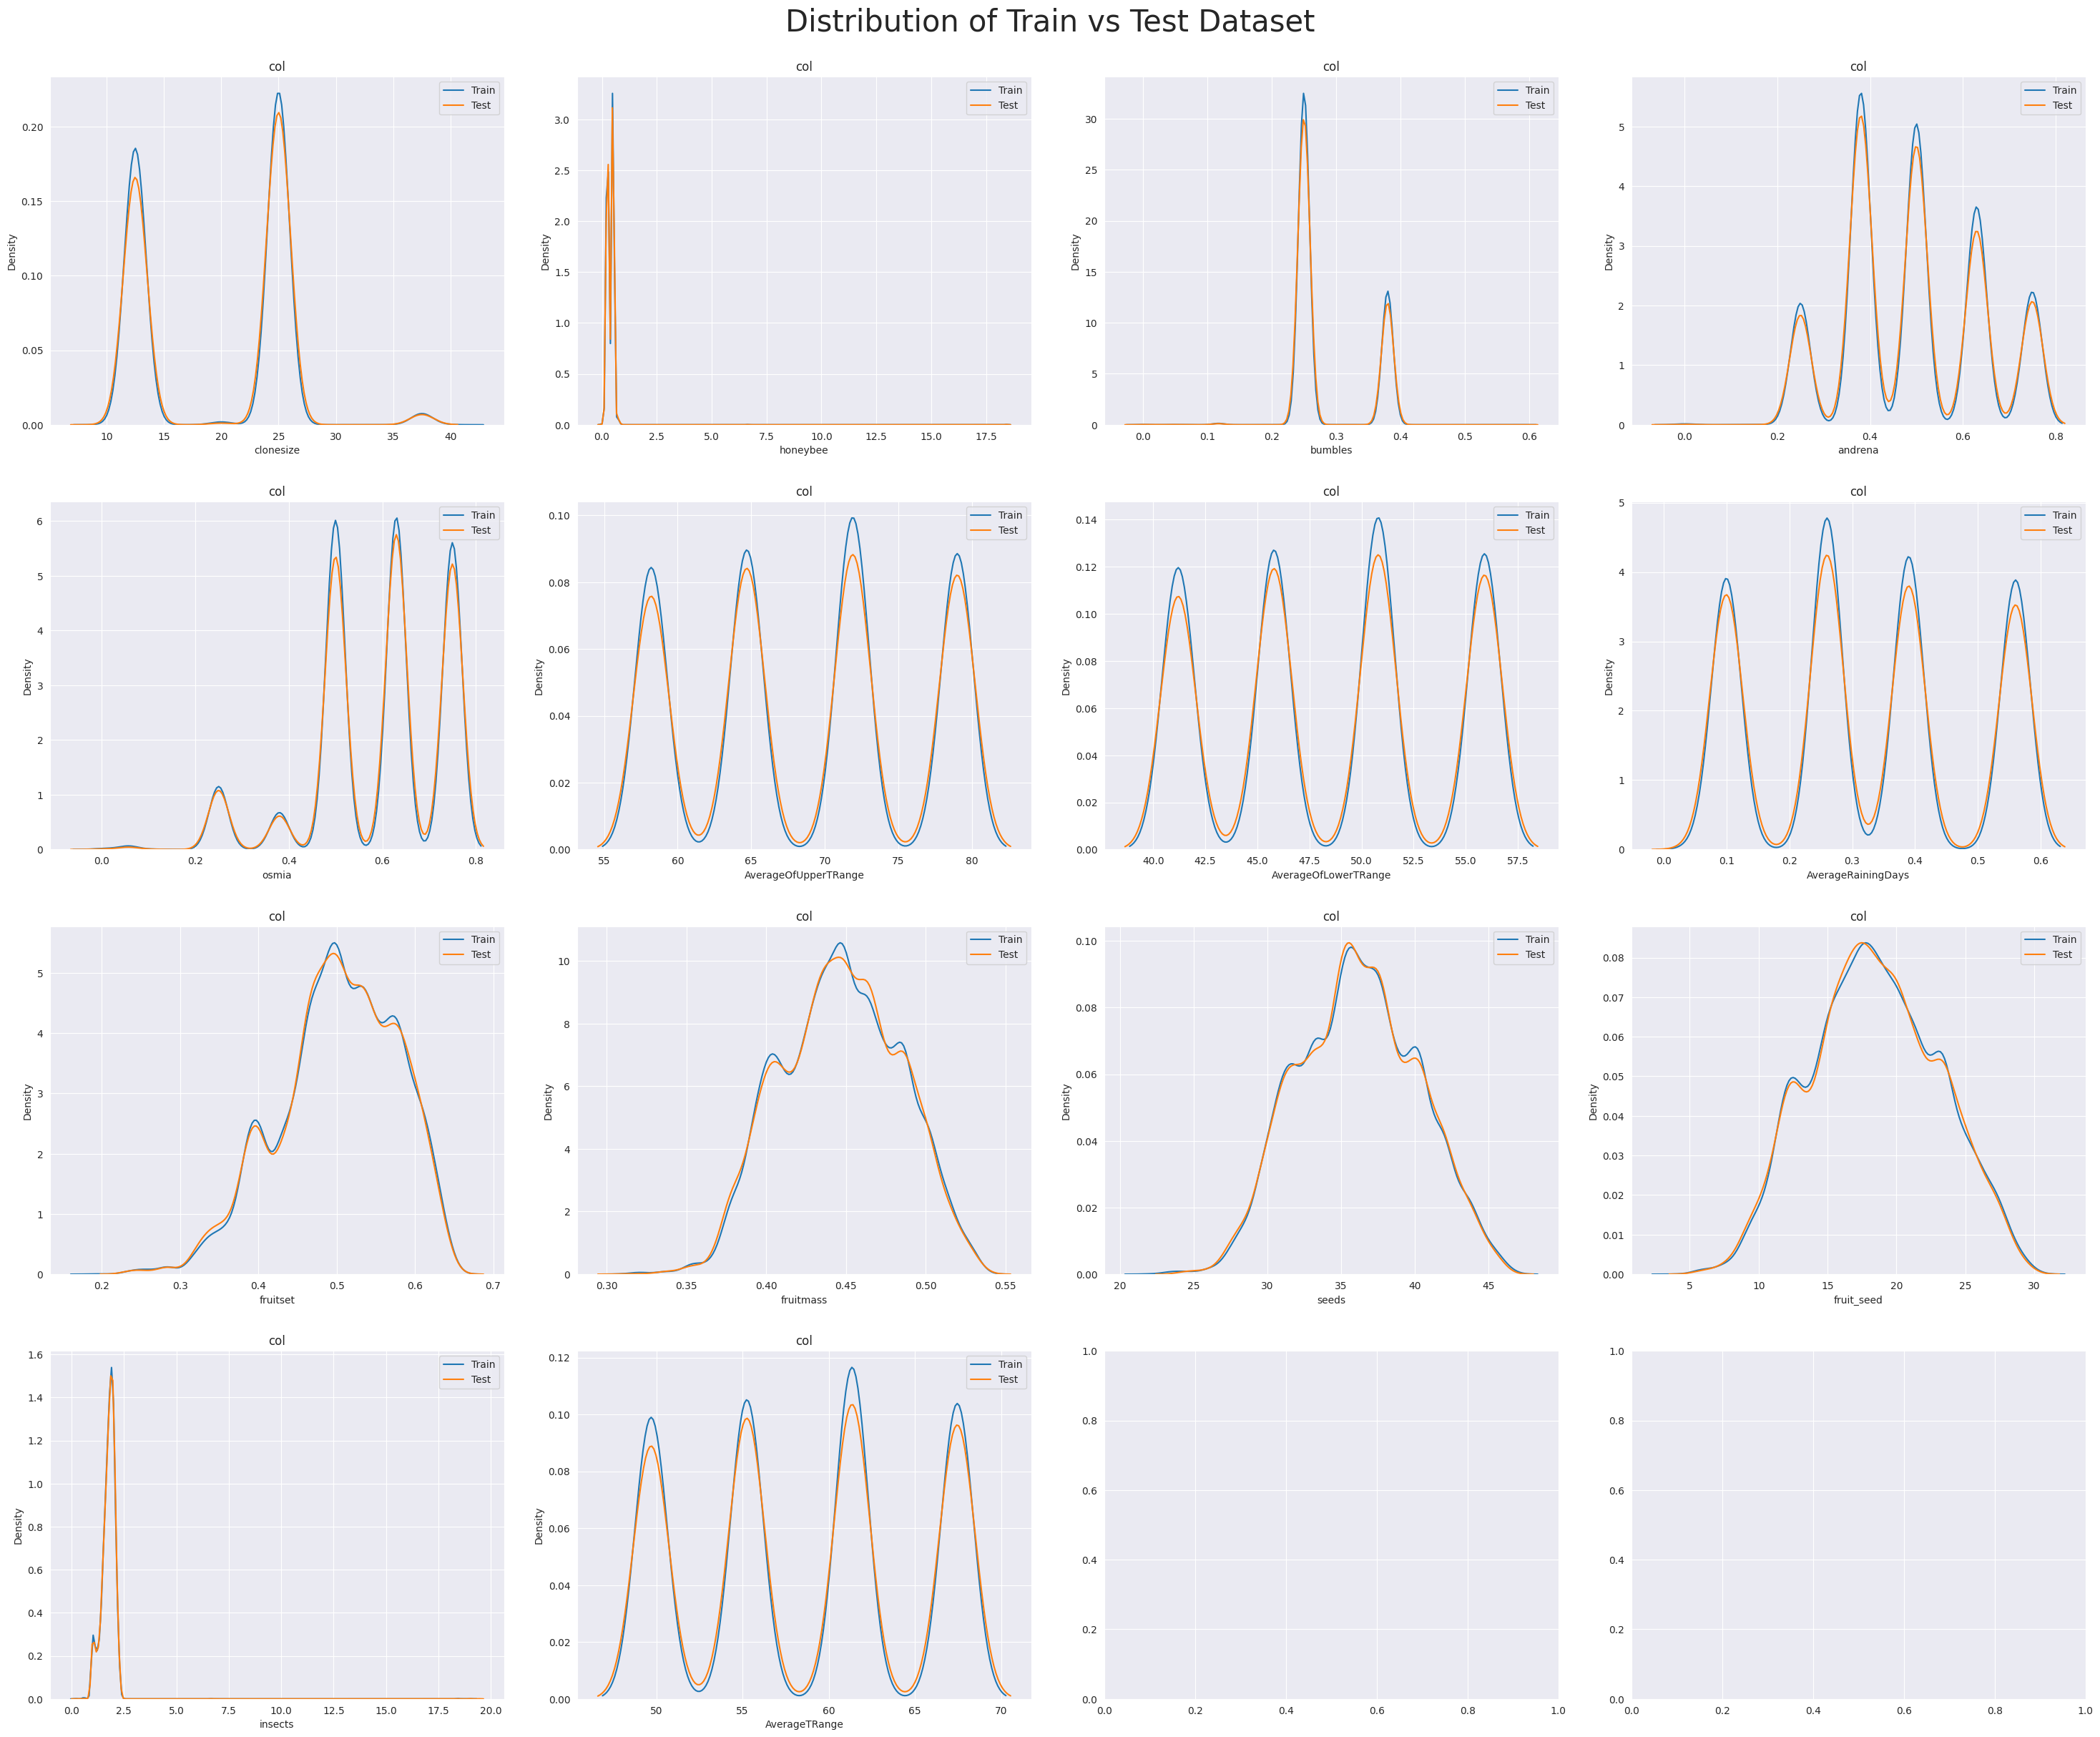

In [20]:

fig,ax = plt.subplots(int(np.ceil(len(X.columns)/4)),4, figsize = (30,25))
for i,col in enumerate(X.columns):
    ax = np.ravel(ax)

    sns.kdeplot(x= X[col] , label = 'Train', ax = ax[i])
    sns.kdeplot(x= test[col], label = 'Test', ax = ax[i] )
    
    ax[i].legend()
    ax[i].set_title(f"col")

plt.suptitle("Distribution of Train vs Test Dataset",fontsize = 30)
plt.tight_layout(pad =3)
plt.show()

## Correlation Matrix

* Dataset looks highly correlated with target field

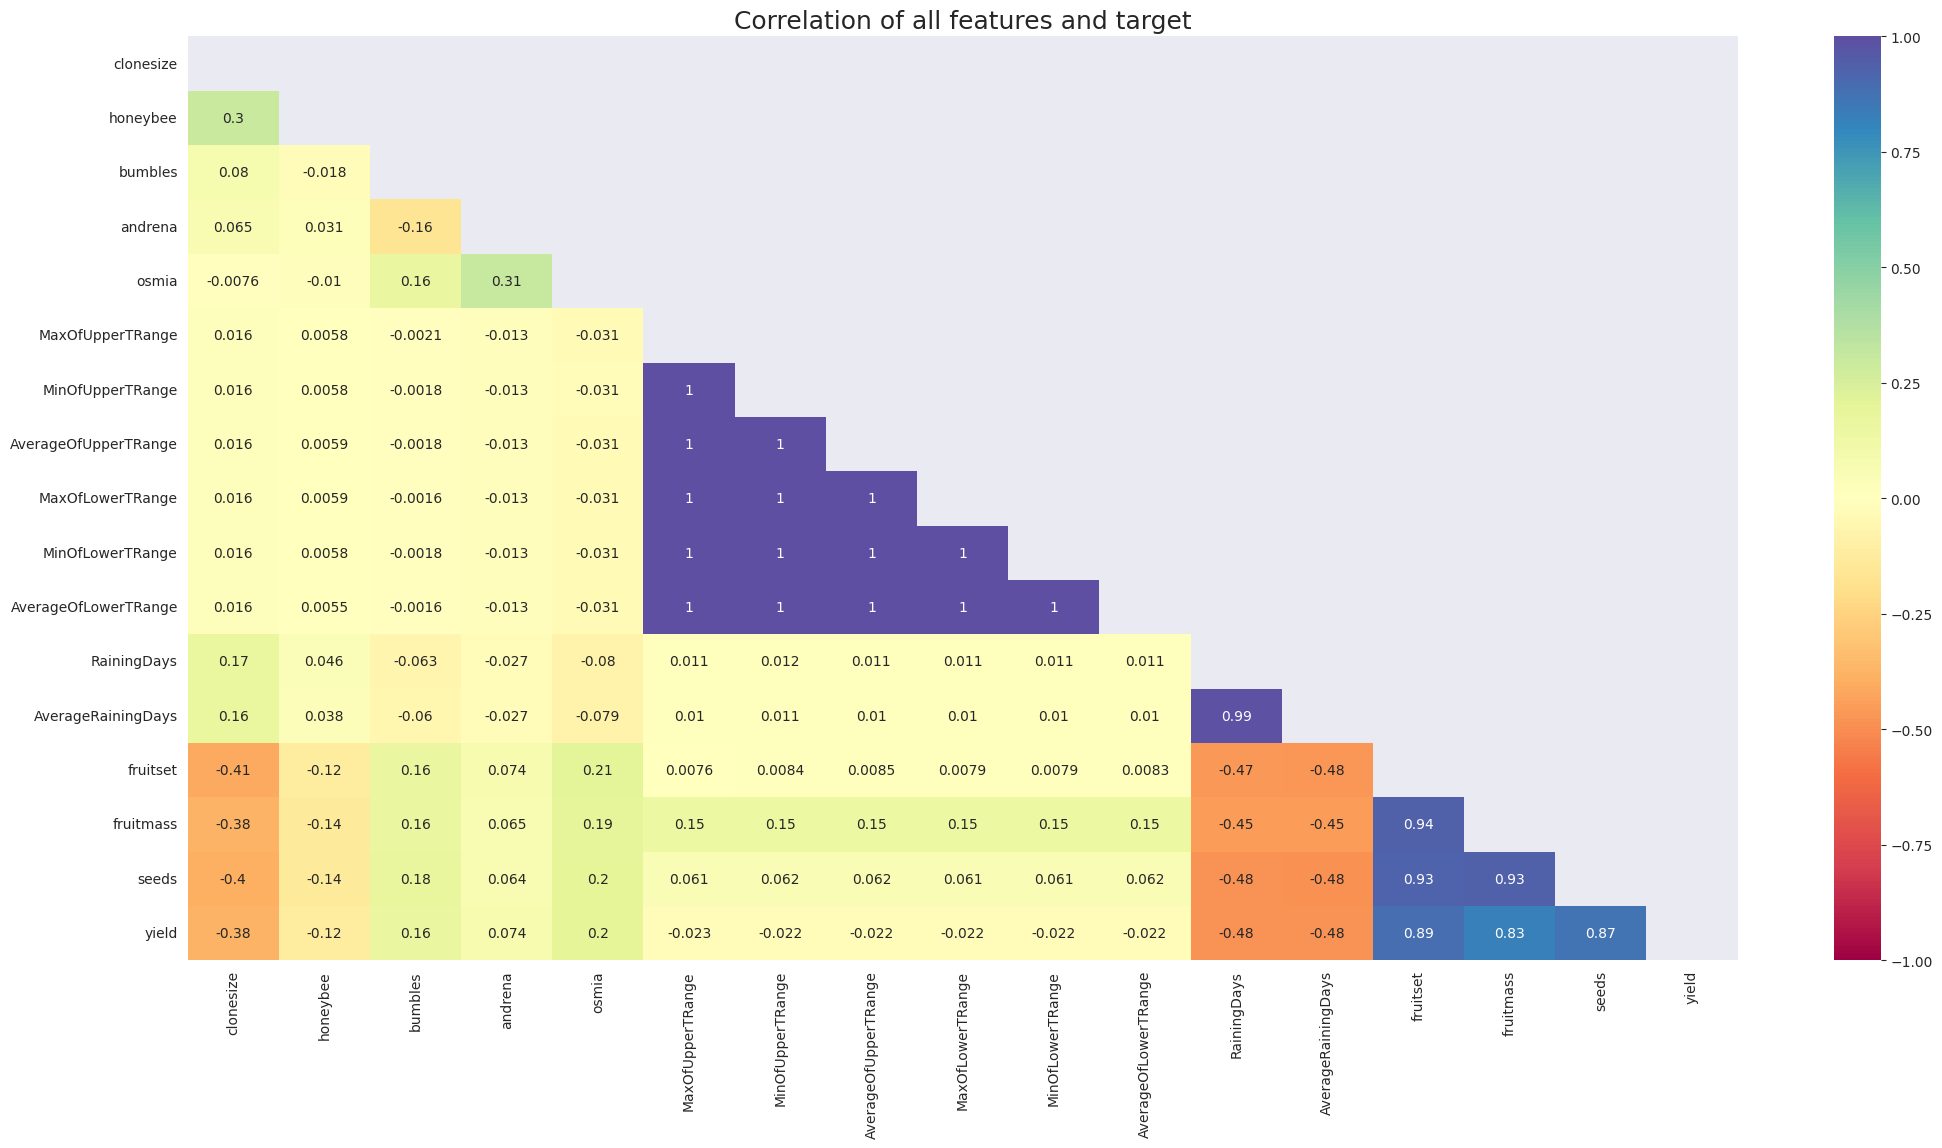

In [21]:
plt.figure(figsize = (25,12))

corr = train.corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

## Outlier Analaysis

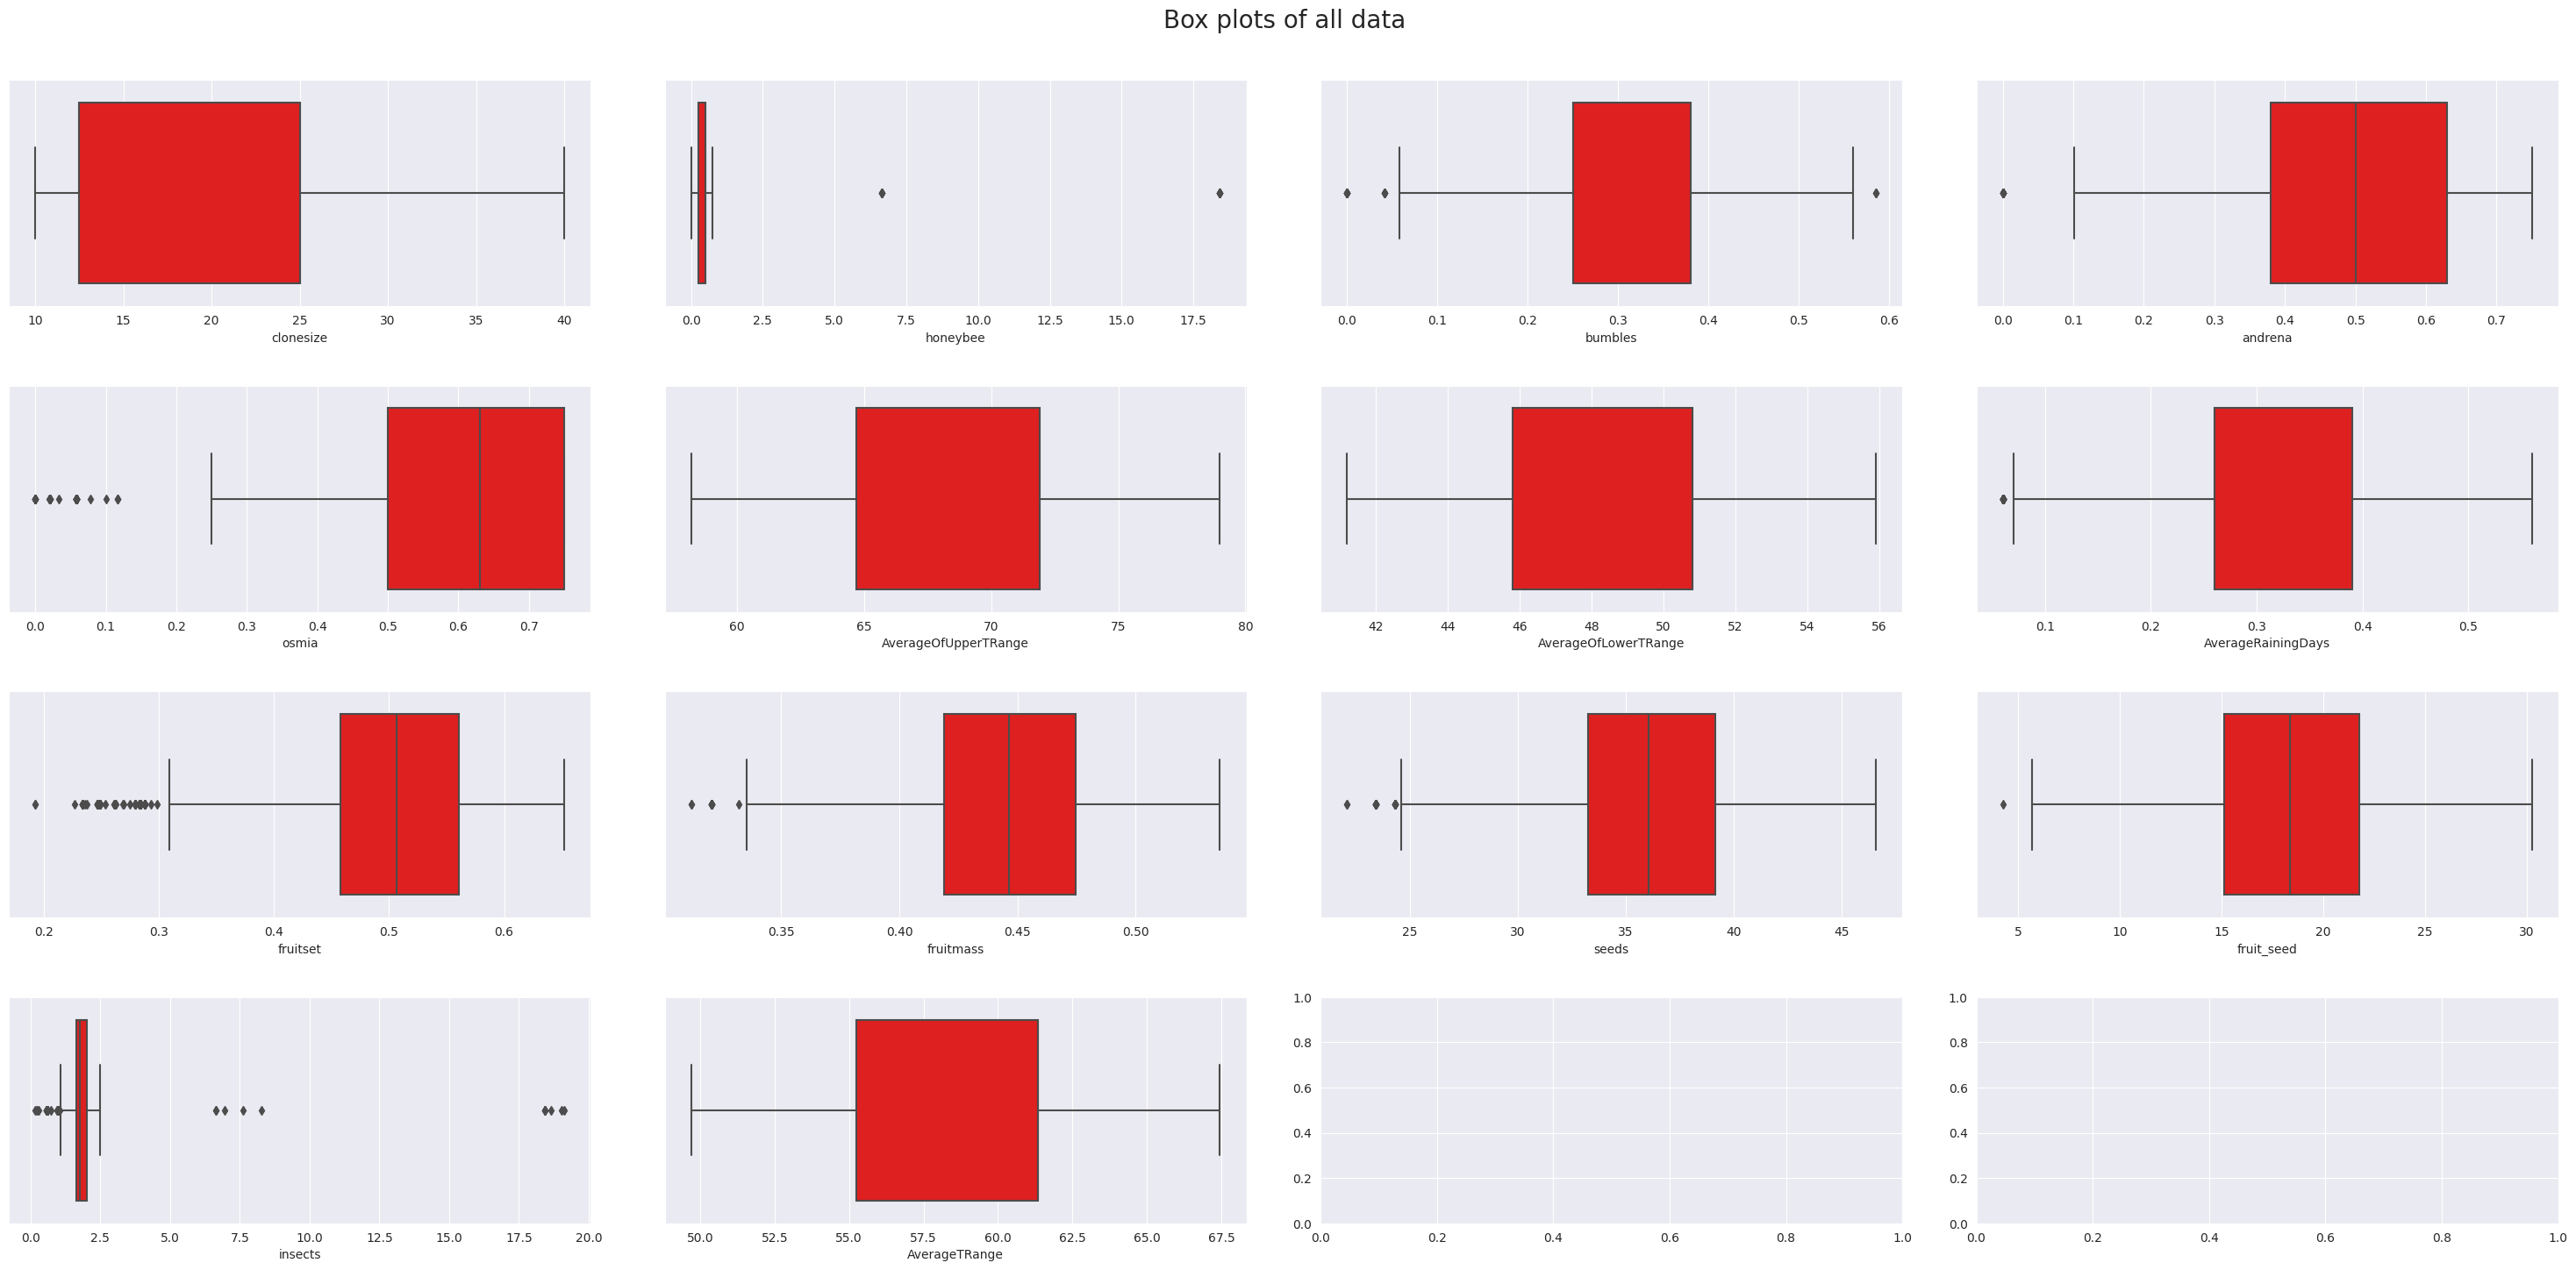

In [22]:
fig,ax = plt.subplots(int(np.ceil(len(X.columns)/4)),4,figsize = (30,15))
ax = np.ravel(ax)

for i,col in enumerate(X.columns):
    sns.boxplot(ax = ax[i], x = X[col], color= "red")

fig.suptitle("Box plots of all data ",fontsize = 20)
plt.tight_layout(pad=3)
plt.show()

## Standardize the numerical features in the dataset

In [23]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
numerical_cols = list(X.select_dtypes(include=['int','float']))
X_numerical = scaler.fit_transform(X[numerical_cols].values)


## Split the train data into train test datasets for modelling

In [24]:
# Split the data into training and test 
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_numerical,y.to_numpy(),test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape



((12847, 14), (3212, 14), (12847,), (3212,))

## Defining the Dataset and Dataloader classes for test and train

In [25]:
# Define the DataLoader for train and test data
from torch.utils.data import Dataset, DataLoader
# Train Data
class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
# Test Data   
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

## Converting the dataset into torch tensor format

In [26]:
# Instantiate the Train and Test data class
import torch
train_data = TrainData(torch.tensor(data=X_train,dtype=torch.float32,requires_grad=True),
                       torch.tensor(data=y_train,dtype=torch.float32,requires_grad=True))

test_data = TrainData(torch.tensor(data=X_test,dtype=torch.float32,requires_grad=True),
                       torch.tensor(data=y_test,dtype=torch.float32,requires_grad=True))


## Creating the baseline model

In [27]:
import torch

class RegressionBlueBerryNNet(torch.nn.Module):
    def __init__(self,input_features):
        super(RegressionBlueBerryNNet,self).__init__()
        # Number of input features is 16.
        self.input_layer = torch.nn.Linear(input_features,1)
        self.relu = torch.nn.ReLU()     
    
    def forward(self,inputs):
        x = self.relu(self.input_layer(inputs))
        return x

## Defining the earlystopping for pytorch

In [28]:
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0.1,test_loss=None):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, test_loss):
        if self.best_loss == None:
            self.best_loss = test_loss
        elif self.best_loss - test_loss > self.min_delta:
            self.best_loss = test_loss
            self.counter = 0
        elif self.best_loss - test_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

## Defining the code to run both on CPU and GPU

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Instantiating the model

In [30]:
model = RegressionBlueBerryNNet(X_train.shape[1])
model.to(device)

print(model)

RegressionBlueBerryNNet(
  (input_layer): Linear(in_features=14, out_features=1, bias=True)
  (relu): ReLU()
)


## Creating baseline skorch model with default params

In [31]:
from skorch.regressor import NeuralNetRegressor
# create model with skorch
model_00 = NeuralNetRegressor(
    model,
    criterion=torch.nn.L1Loss,
    optimizer=torch.optim.SGD,
    max_epochs=100,
    batch_size=32,
    verbose=False
)
 


##  Performing the gridsearch on params

In [44]:
param_grid = {
    'batch_size': [10, 20,40,60]
    #'max_epochs': [50, 100],
    #'optimizer': [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad, torch.optim.Adadelta,
                # torch.optim.Adam, torch.optim.Adamax, torch.optim.NAdam],
    #'optimizer__lr': [0.001, 0.01, 0.1, 0.2, 0.3],
    #'optimizer__momentum':[ 0.8, 0.9],

    #'module__activation': [torch.nn.Identity, torch.nn.ReLU, torch.nn.ELU, torch.nn.ReLU6,
                         #  torch.nn.GELU, torch.nn.Softplus, torch.nn.Softsign, torch.nn.Tanh,
                         #  torch.nn.Sigmoid, torch.nn.Hardsigmoid],
   #  'module__n_neurons': [1, 5, 10]                     
                    
}
grid = GridSearchCV(estimator=model_00, param_grid=param_grid, n_jobs=3, cv=6,verbose=1)
grid_result = grid.fit(torch.tensor(X_test, dtype=torch.float32),  torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1))

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 6 folds for each of 4 candidates, totalling 24 fits
Best: -19.554163 using {'batch_size': 10}


## Showcasing the mean and std for grid result

In [45]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-19.554163 (1.249265) with: {'batch_size': 10}
-20.103036 (1.297670) with: {'batch_size': 20}
-20.386855 (1.321723) with: {'batch_size': 40}
-20.485172 (1.330321) with: {'batch_size': 60}


## Hyper parameter tunning 

In [46]:
# Model Parameters 
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.1
MOMENTUM = 0.9
NEURONS =10

## Defining the loss and optimizer

In [47]:
# Define the loss and optimizer 
criterion = torch.nn.L1Loss() 
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE,momentum=MOMENTUM)



## Creating the Dataloader for train and test 

In [48]:
# Initialize the DataLoader 
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

## Traning the Model :)

In [49]:
from tqdm.notebook import tqdm
#early_stopper = EarlyStopper(patience=3, min_delta=10)
model.train()
for e in tqdm(range(1, EPOCHS+1)):
    epoch_loss = 0.0
    epoch_loss_test = 0.0
    train_loss =[]
    test_loss =[]
    
     # Every data instance is an input + label pair
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
       
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Make predictions for this batch
        y_pred = model(X_batch)
        
        # Compute the loss and its gradients
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        loss.backward()
            #return loss
        # Adjust learning weights
        optimizer.step()
        #loss = closure()
        # Gather data and report
        epoch_loss += loss.item()
    
    
    with torch.no_grad():
        for X_batch_test, y_batch_test in test_loader :
            X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)
            y_pred_test = model(X_batch_test)
            loss_test = criterion(y_pred_test, y_batch_test.unsqueeze(1))
            epoch_loss_test += loss_test.item()
        
    
        
    if e%10 == 0:
        train_loss.append(epoch_loss/len(train_loader))
        test_loss.append(epoch_loss_test/len(test_loader))
        print(f'Epoch {e+0:03}: | Train_Loss: {epoch_loss/len(train_loader):.5f} | Test_Loss: {epoch_loss_test/len(test_loader):.5f}')
    
    earrly_stopping = EarlyStopping(epoch_loss_test)
    if earrly_stopping.early_stop:
        break
        

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 010: | Train_Loss: 4060.30069 | Test_Loss: 3982.07348
Epoch 020: | Train_Loss: 644.52057 | Test_Loss: 544.55420
Epoch 030: | Train_Loss: 366.14234 | Test_Loss: 369.70392
Epoch 040: | Train_Loss: 360.48713 | Test_Loss: 364.79033
Epoch 050: | Train_Loss: 357.86674 | Test_Loss: 362.83308
Epoch 060: | Train_Loss: 357.24709 | Test_Loss: 362.17121
Epoch 070: | Train_Loss: 356.61631 | Test_Loss: 361.76347
Epoch 080: | Train_Loss: 356.28288 | Test_Loss: 361.59875
Epoch 090: | Train_Loss: 356.31469 | Test_Loss: 361.68948
Epoch 100: | Train_Loss: 355.97651 | Test_Loss: 361.60895


## Executing model on test data

### Checking the summary of the test data

In [50]:
summary('test',test)

test shape: (10194, 20)


,dtypes,null,unique,min,median,max,mean,std,inf,duplicate
id,int64,0,10194,15289.000000,20385.500000,25482.000000,20385.500000,2942.898656,0,0
clonesize,float64,0,5,10.000000,25.000000,37.500000,19.795958,6.591864,0,0
honeybee,float64,0,7,0.000000,0.500000,18.430000,0.391606,0.390022,0,0
bumbles,float64,0,8,0.000000,0.250000,0.585000,0.286307,0.059867,0,0
andrena,float64,0,12,0.000000,0.500000,0.750000,0.491328,0.148166,0,0
osmia,float64,0,14,0.000000,0.630000,0.750000,0.593222,0.139897,0,0
MaxOfUpperTRange,float64,0,7,69.700000,86.000000,94.600000,82.207014,9.153442,0,0
MinOfUpperTRange,float64,0,6,39.000000,52.000000,57.200000,49.697204,5.552286,0,0
AverageOfUpperTRange,float64,0,6,58.200000,71.900000,79.000000,68.687816,7.647629,0,0
MaxOfLowerTRange,float64,0,5,50.200000,62.000000,68.200000,59.256465,6.617055,0,0


In [51]:
test.drop(columns=['MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays'],axis=1,inplace=True)

## Creating the Test variable 

In [52]:
X_val=test.loc[:, test.columns != 'id']

## Filtering the continous columns

In [53]:
numerical_cols_test = list(X_val.select_dtypes(include=['int','float']))

## Standardizing the test data as train data

In [54]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = StandardScaler()
X_numerical_test = scaler.fit_transform(X_val[numerical_cols_test].values)

## Defining the Test Dataset class

In [55]:
# Test Data   
class TestingData(Dataset):
    
    def __init__(self, X_test_data):
        self.X_test_data = X_test_data
        
    def __getitem__(self, index):
        return self.X_test_data[index]
        
    def __len__ (self):
        return len(self.X_test_data)

## Creating the DataLoader class

In [56]:
test_data_model = TestingData(torch.tensor(data=X_numerical_test,dtype=torch.float32))
test_data_model_loader = DataLoader(dataset=test_data_model, batch_size=BATCH_SIZE)

## Generating the yield values for test data

In [57]:
# Validating the model on test data
yield_target = []
model.eval()
with torch.no_grad():
    for X_batch_test in test_data_model_loader:
        X_batch_test = X_batch_test.to(device)
        y_test_pred = model(X_batch_test)
        y_pred_tag = torch.round(y_test_pred)
        yield_target.append(y_pred_tag.cpu().numpy())

yield_target = [a.squeeze().tolist() for a in yield_target]

## Creating the submission file

In [58]:
yield_submission=[]
for col in yield_target:
    for val in col:
        yield_submission.append(val)
#yield_submission
df_test = pd.DataFrame(data={'id': test['id'],'yield': yield_submission})
df_test.to_csv('submission.csv', index=False)